# Use Case 4: Comparing Mutation Protein Abundance

<b>Standard imports for playing with and plotting data frames.</b>

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

<b>Import CPTAC data</b>

In [3]:
import CPTAC

Loading Clinical Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Data...

 ******PLEASE READ******


In [4]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

### Test for protein levels (mutation in a gene with protein levels of any protein)
<b>Note:</b> You can put any number of proteins in the list and it will compare that gene with the protein levels of all of them

In [39]:
gene = 'TP53'
protList = ['TP53BP2']

pcutoff = 0.05/len(protList)
print(pcutoff)

genedf = somatic_mutations[gene].to_frame()
for protein in protList:
    if protein in proteomics.columns:
        proteindf = proteomics[protein].to_frame()
        cross = genedf.add(proteindf, fill_value=0).dropna(axis=0)
        mutated = cross.loc[cross[gene] == 1.0]
        wt = cross.loc[cross[gene] == 0.0]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        print("Test for " + protein + ": ")
        print(ttest)

0.05
Test for TP53BP2: 
Ttest_indResult(statistic=3.4447637901646937, pvalue=0.000842718770135264)


<b>Boxplot (should be ready to go right after running the above cell)</b>

[Text(0,0.5,'Proteomics'), Text(0.5,0,'Somatic Gene Mutation')]

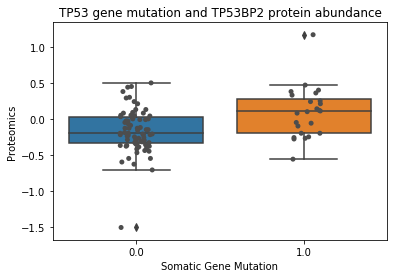

In [40]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=protList[0])
somatic_boxplot.set_title(gene + " gene mutation and " + protList[0] + " protein abundance")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=protList[0],jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Proteomics")

### Test for phosphorylation levels (mutation in a gene with phosphorylation of any protein)

In [20]:
gene = 'TP53'
sites = phos.filter(regex='TP53')
sigResults = [];

genedf = somatic_mutations[gene].to_frame()
cross = genedf.add(sites, fill_value=0)
mutated = cross.loc[cross[gene] == 1.0]
wt = cross.loc[cross[gene] == 0.0]

pcutoff = 0.05/len(cross.columns)
print(pcutoff)

for loc in cross.columns:
    if not loc == gene:
        mutsitedf = mutated[[gene, loc]].dropna()
        wtsitedf = wt[[gene, loc]].dropna()
        ttest = scipy.stats.ttest_ind(mutsitedf[loc], wtsitedf[loc])
        if ttest[1] <= pcutoff:
            sigResults.append(loc)
            print('Results for ' + loc + ': ')
            print(ttest)

0.0005376344086021505
Results for TP53-S315: 
Ttest_indResult(statistic=4.5116732692720705, pvalue=2.81407273681229e-05)
Results for TP53BP1-S1431: 
Ttest_indResult(statistic=4.819602521158986, pvalue=6.619797586243582e-06)
Results for TP53BP1-S1435: 
Ttest_indResult(statistic=4.74121449433656, pvalue=7.210127219127611e-06)
Results for TP53BP1-S1683: 
Ttest_indResult(statistic=4.687964245279931, pvalue=9.535677192577145e-06)
Results for TP53BP1-S1706: 
Ttest_indResult(statistic=5.643489011660524, pvalue=3.294769768234183e-07)
Results for TP53BP1-S1763: 
Ttest_indResult(statistic=7.045858275075653, pvalue=7.196228903923844e-10)
Results for TP53BP1-S1764: 
Ttest_indResult(statistic=4.387625978778714, pvalue=3.4228154547355373e-05)
Results for TP53BP1-S867: 
Ttest_indResult(statistic=4.364161237074746, pvalue=5.013280141618629e-05)


[Text(0,0.5,'Phosphoproteomics'), Text(0.5,0,'Somatic Gene Mutation')]

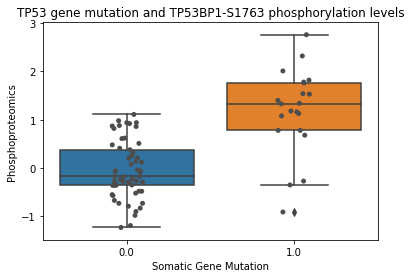

In [29]:
somatic_boxplot = sns.boxplot(data=cross, x=gene ,y=sigResults[5])
somatic_boxplot.set_title(gene + " gene mutation and " + sigResults[5] + " phosphorylation levels")
somatic_boxplot = sns.stripplot(data=cross, x=gene, y=sigResults[5],jitter=True, color=".3")
somatic_boxplot.set(xlabel="Somatic Gene Mutation",ylabel="Phosphoproteomics")

### Test for phosphorylation levels and protein abundance

In [62]:
phosProt = phos.filter(regex='FGFR') 
protein = 'STAT1'

proteindf = proteomics[protein].to_frame()
cross = proteindf.add(phosProt, fill_value=0)

pcutoff = 0.05/len(cross.columns)
print(pcutoff)

for loc in cross.columns:
    if not loc == protein:
        oneSitedf = cross[[loc, protein]].dropna(axis=0)
        pearsonresult = pearsonr(oneSitedf[loc], oneSitedf[protein])
        print("Results for " + loc)
        print(pearsonresult)

0.01
Results for FGFR1OP-S152
(-0.03333259196372111, 0.7592285091138733)
Results for FGFR1OP-S156
(0.15158405081358645, 0.07486026784097914)
Results for FGFR1OP-S160
(0.22275628733958308, 0.008395276554038449)
Results for FGFR1OP-S279
(0.1048119063268295, 0.25458624353413445)


<b>Plot of the data. You'll have to enter the phosphorylation site and protein you want</b>

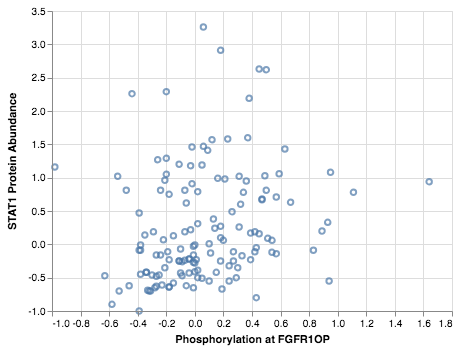

In [65]:
alt.Chart(cross).mark_point().encode(
    alt.X('FGFR1OP-S160', type='quantitative', axis=alt.Axis(title="Phosphorylation at FGFR1OP")),
    alt.Y('STAT1', type='quantitative', axis=alt.Axis(title="STAT1 Protein Abundance"))
)